# XZZX decoder for hashing bound

The XZZX code is a recently designed one for obtaining higher threshold in biased noise. The original paper can be found [here](https://arxiv.org/pdf/2009.07851.pdf). The XZZX code is good at preserving X/Z biased noise. It achieves this with a built-in symmetry for X/Z noise, i.e. X errors cause syndrome flips in a mutually orthogonal direction with that of the Z errors. Thus, the larger the bias, the more the code should behave like a repetition code. Theoretically, in the event of pure X/Z noise on data qubits, the code should obtain a threshold of ~0.5, just like the repetition code. This is a dramatic improvement from the original XX/ZZ code. 

The script "Hashing.py" contains both the noise model and the decoder. The current noise model is one that considers hashing bound only for Z-biased noise, and the decoder follows the original scheme of the XZZX decoder with an additional option to consider multi-path summation as introduced in the XX/ZZ code decoder. To get started with the decoder, first load in all the necessary modules as follows -- 

In [1]:
# Be careful of the dependencies in your own config
from Hashing_rotated import XZZXDecoder
import Hashing_rotated as hs
import numpy as np
import multiprocessing as mp
import time
from itertools import product

Now, an extra word on the decoding scheme. 

Similar to the XX/ZZ code, the XZZX code can be decoded using two subgraphs (named as "A" and "B", corresponding to the "Z" and "X" graph in XX/ZZ code respectively) in our script. This choice of the subgraph is not for decoding X/Z stabilizers separately, since there is only one stabilizer in the XZZX code. We can use the subgraph because only syndromes that crosses integer numbers of qubits can be connected with each other; in other words, the syndromes between the two subgraphs will not connect with each other. Therefore, there is no need to put the in the same graph. Splitting the graph into two will also cut the computation time by half at most. 

Different form the XX/ZZ code, in each subgraph, the XZZX code will weigh the edges differently to distinguish the X noise from the Z noise. In this script, we consider the right diagonal (y=x direction) to be the X noise edge, and the left diagonal (y=-x direction) to be the Z noise edge. The weighing formula used are

X edge: weight $= \ln\left(\frac{1- 2P_x - P_z}{2 P_z}\right)$

Z edge: weight $= \ln\left(\frac{1- 2P_x - P_z}{P_x + P_z}\right)$

For both weight, we added the probability of Y noise, which is equivalent to the probability of X noise in the biased noise model, resulting in the factor of 2.

To see a visualization of the our syndrome graphs for a d = 5 lattice with bias of 2 (i.e, the Z noise is twice more likely than the X and Y noise respectively) and $P_z = 0.04$, we can use the supplementary plotting function in the script as follows --

Subgraph A: 



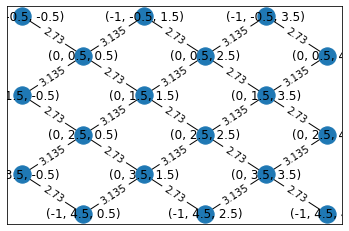

Subgraph B: 



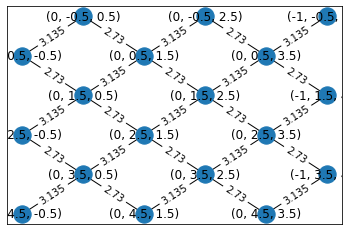

In [2]:
decoder = XZZXDecoder(5, 0.04, 2)
G = decoder.make_syndrome_graph()
print("Subgraph A: \n")
hs.graph_2D(G["A"],'distance')
print("Subgraph B: \n")
hs.graph_2D(G["B"],'distance')

The edges with smaller weight (i.e. distance) are the Z edges, which are more likely to be chosen in MWPM. 

Finally, a word on the logical X/Z choice. Different from the XX/ZZ code or the XZZX code on the planar lattice, the X logical is chosen as $X_1Z_2X_3Z_4 \dots$ on the bottom edge, and the Z logical is chosen as $Z_1X_2Z_3X_4 \dots$ on the right edge, where the index 1 qubit either starts from the left or from the top. One may check for the legitimacy of this choice on their own. But such choice result in only one repetition code like diagonal in the event of large/infinity bias (i.e. the longest diagonal). This result in a smaller number of errors on a lattice then the planar one. Thus, in order to see a stable outcome from the large bias from large lattices, we suggest switching to the planar lattice, where you can simulate # $\times 1$ lattice, where # is a distance of your choice. 

Now, we present a simple driver code for the script.

In [9]:
def Simulate(pz, eta, m):
    shots = 100
    d = 7
    t1 = t2 = t3 = 0
    decoder = XZZXDecoder(d, pz, eta)
    for s in range(shots):
        err_syndrome, xL, zL = decoder.get_error_syndrome()
        error_graph = decoder.make_error_graph(err_syndrome, multi=m)
        matches_a = hs.mwpm(error_graph["A"]) 
        matches_b = hs.mwpm(error_graph["B"])
        xL_a, zL_a = decoder.error_correct(matches_a)
        xL_b, zL_b = decoder.error_correct(matches_b)
        xL_t = xL_a + xL_b
        zL_t = zL_a + zL_b

        if xL_t % 2 != xL % 2 or zL_t % 2 != zL % 2:
            t1 += 1
        if xL_t % 2 != xL % 2:
            t2 += 1
        if zL_t % 2 != zL % 2:
            t3 += 1

    t1 = t1/shots
    t2 = t2/shots
    t3 = t3/shots
    
    print(eta, round(pz,3), m, t1, t2, t3)
    
    return


if __name__ == '__main__':
    starttime = time.time()
    probs = np.linspace(0.04, 0.06, 6)
    eta = [1,2]
    m = [0,1]
    print("eta, pz, m, t1, t2, t3:\n")
    pool = mp.Pool()
    pool.starmap(Simulate, product(probs, eta, m))
    pool.close()
    print('Time taken = {} seconds'.format(time.time() - starttime))

eta, pz, m, t1, t2, t3:

2 0.04 0 0.01 0.0 0.01
1 0.04 0 0.04 0.01 0.04
2 0.044 0 0.03 0.01 0.02
2 0.048 0 0.03 0.01 0.02
1 0.052 0 0.21 0.11 0.11
1 0.044 0 0.13 0.04 0.11
 0.048 0 0.15 0.12 0.06
2 0.052 0 0.09 0.08 0.02
2 0.056 0 0.06 0.03 0.04
1 0.056 0 0.29 0.14 0.18
1 0.06 0 0.3 0.16 0.15
2 0.06 0 0.15 0.09 0.07
2 0.044 1 0.03 0.02 0.01
2 0.048 1 0.07 0.04 0.04
2 0.04 1 0.01 0.01 0.0
2 0.052 1 0.07 0.05 0.02
1 0.04 1 0.11 0.05 0.06
1 0.044 1 0.06 0.04 0.02
1 0.048 1 0.19 0.13 0.09
2 0.056 1 0.04 0.03 0.01
1 0.052 1 0.19 0.11 0.09
1 0.056 1 0.36 0.21 0.2
2 0.06 1 0.11 0.06 0.05
1 0.06 1 0.29 0.24 0.13
Time taken = 38.45343089103699 seconds
